In [88]:
%load_ext autoreload
%autoreload 2

import os
import re
import sys

sys.path.append(os.path.abspath("../"))

import faiss
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from src.data_utils import create_training_dataset
from src.model_xg import train_and_plot
from src.utils import compute_auc_roc, evaluate_prediction

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 400)


load_dotenv()

from src.data_utils import PodcastContainer, load_clean_scores
from src.player_utils import PlayerUtil
from src.utils import get_repo_root

scores = load_clean_scores(["2023-24"])
# scores = load_clean_scores()


# scores['outperform_next'] = scores.groupby('personId')['outperformed'].shift(-1)
scores.head(5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,outperform_next,outperform_next_5,outperform_next_10,injured_next,injured,fantasyDiff
390948,2023-24,2023-10-24,22300061,LAL @ DEN,lakers,lakers,2544,lebron james,29.016667,10,16,0.625,1,4,0.25,0,1,0.0,1,7,8,5,1,0,0,1,21,7,40.50,49.35,0,1,False,False,0.0,0,-8.85
390949,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.00,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,11.60,0,0,False,False,1.0,1,-11.60
390950,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,202704,reggie jackson,24.066667,3,8,0.375,2,5,0.40,0,0,0.0,0,3,3,1,1,0,2,0,8,11,14.25,19.10,0,1,True,False,0.0,0,-4.85
390951,2023-24,2023-10-24,22300061,LAL @ DEN,lakers,lakers,203076,anthony davis,34.150000,6,17,0.353,1,2,0.50,4,4,1.0,1,7,8,4,0,2,2,3,17,-17,36.00,51.80,0,1,True,True,0.0,0,-15.80
390952,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,203200,justin holiday,0.000000,0,0,0.000,0,0,0.00,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,8.20,0,0,False,False,1.0,1,-8.20


In [89]:
scores[scores.personId == 201599].head(20)

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,outperform_next,outperform_next_5,outperform_next_10,injured_next,injured,fantasyDiff
390949,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.0,0,0,0.000,0,0,0,0,0,0,0,0,0,0,0.00,11.60,0,0,False,False,1.0,1,-11.60
391433,2023-24,2023-10-27,22300078,DEN @ MEM,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.0,0,0,0.000,0,0,0,0,0,0,0,0,0,0,0.00,11.60,0,0,False,False,1.0,1,-11.60
391908,2023-24,2023-10-29,22300095,DEN @ OKC,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.0,0,0,0.000,0,0,0,0,0,0,0,0,0,0,0.00,9.55,0,0,False,False,1.0,1,-9.55
392324,2023-24,2023-10-30,22300110,DEN vs. UTA,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.0,0,0,0.000,0,0,0,0,0,0,0,0,0,0,0.00,3.90,0,0,False,False,1.0,1,-3.90
392679,2023-24,2023-11-01,22300123,DEN @ MIN,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.0,0,0,0.000,0,0,0,0,0,0,0,0,0,0,0.00,3.90,0,0,False,False,1.0,1,-3.90
393062,2023-24,2023-11-03,22300006,DEN vs. DAL,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.0,0,0,0.000,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0,1,False,False,0.0,1,0.00
393304,2023-24,2023-11-04,22300139,DEN vs. CHI,nuggets,nuggets,201599,deandre jordan,12.250000,0,0,0.000,0,0,0.0,1,2,0.500,1,0,1,1,0,0,1,2,1,-10,3.25,0.00,1,0,False,False,1.0,0,3.25
393759,2023-24,2023-11-06,22300156,DEN vs. NOP,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.0,0,0,0.000,0,0,0,0,0,0,0,0,0,0,0.00,0.65,0,0,False,False,1.0,1,-0.65
394106,2023-24,2023-11-08,22300169,DEN vs. GSW,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.0,0,0,0.000,0,0,0,0,0,0,0,0,0,0,0.00,0.65,0,0,False,False,1.0,1,-0.65
394692,2023-24,2023-11-12,22300182,DEN @ HOU,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.0,0,0,0.000,0,0,0,0,0,0,0,0,0,0,0.00,0.65,0,0,False,False,1.0,1,-0.65


## Baseline XGBoost

Sliding Window MAE: 16.779297549188815
Model MAE: 0.4473593372454263

Evaluation Metrics
----------------------------------------
Accuracy: 0.553
AUC (ROC): 0.563
F1 Score: 0.417
Precision: 0.488, Recall: 0.363
row_auc, accuracy, precision, recall, tnr
0.563, 0.553, 0.488, 0.363, 0.701

Confusion Matrix:
TN, FP
FN, TP

Confusion Matrix (Counts):
[[2276  970]
 [1622  926]]

Confusion Matrix (Percent of Column):
[[58.39 51.16]
 [41.61 48.84]]
----------------------------------------
AUC: 0.5627146706827193


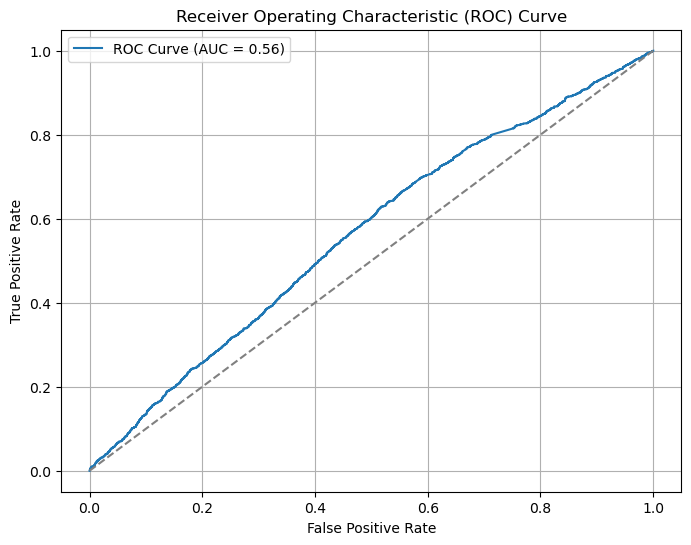

In [80]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

non_lag_features = ["plusMinusPoints"]
lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]
target_col = "outperform_next"

training_dct = create_training_dataset(
    scores, non_lag_features, lag_features, target_col, diff_threshold=5
)

lagged_feat_names = training_dct["lagged_feat_names"]
full_df = training_dct["df"]

# Split training/validation sets
train_size = int(len(full_df) * 0.8)
train_df = full_df.iloc[:train_size]
test_df = full_df.iloc[train_size:]


train_features = non_lag_features + lagged_feat_names
# train_features = lagged_feat_names

result_dct = train_and_plot(train_df, test_df, train_features, target_col)
y_probs = result_dct["y_prob"][:, 1]
y_preds = (y_probs >= 0.5).astype(int)
y_true = test_df[target_col]


results = evaluate_prediction(y_true, y_probs, y_preds)

compute_auc_roc(
    y_true,
    y_probs,
)

## XGBoost w/ Injury

Sliding Window MAE: 16.779297549188815
Model MAE: 0.4095616154642734

Evaluation Metrics
----------------------------------------
Accuracy: 0.590
AUC (ROC): 0.625
F1 Score: 0.508
Precision: 0.538, Recall: 0.482
row_auc, accuracy, precision, recall, tnr
0.625, 0.590, 0.538, 0.482, 0.676

Confusion Matrix:
TN, FP
FN, TP

Confusion Matrix (Counts):
[[2194 1052]
 [1321 1227]]

Confusion Matrix (Percent of Column):
[[62.42 46.16]
 [37.58 53.84]]
----------------------------------------
AUC: 0.6250585795245157


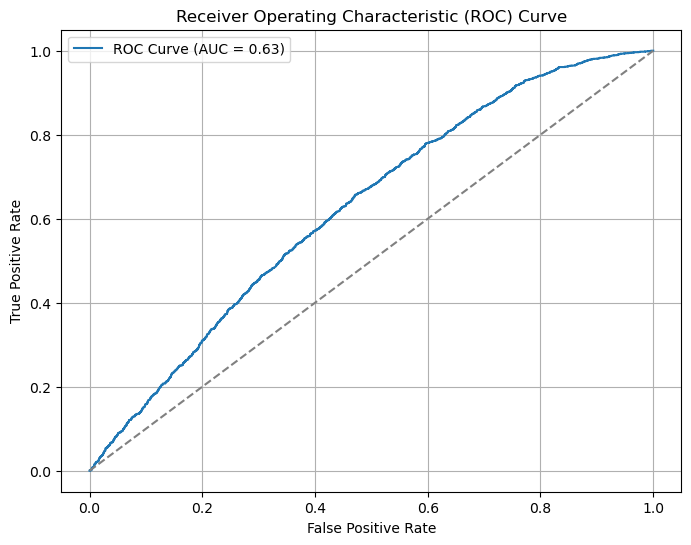

In [104]:
non_lag_features = ["plusMinusPoints", "weighted_injured"]
lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]
target_col = "outperform_next"

training_dct = create_training_dataset(
    scores, non_lag_features, lag_features, target_col, diff_threshold=5
)

lagged_feat_names = training_dct["lagged_feat_names"]
full_df = training_dct["df"]

full_df["weighted_injured"] = (
    0.95 * full_df["injured"]
    + 0.07 * full_df["injured_next"]
    + np.random.normal(0, 0.05, size=len(full_df))
)

# Split training/validation sets
train_size = int(len(full_df) * 0.8)
train_df = full_df.iloc[:train_size]
test_df = full_df.iloc[train_size:]

train_features = non_lag_features + lagged_feat_names

result_dct = train_and_plot(train_df, test_df, train_features, target_col)
y_probs = result_dct["y_prob"][:, 1]
y_preds = (y_probs >= 0.5).astype(int)
y_true = test_df[target_col]


results = evaluate_prediction(y_true, y_probs, y_preds)

compute_auc_roc(
    y_true,
    y_probs,
)

In [17]:
select_cols = [c for c in test_df.columns if not "lag" in c]

r = test_df[select_cols].assign(y_pred=y_preds)
r[r.personId == 201599]

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,outperform_next,fantasyDiff,injured,y_pred
417037,2023-24,2024-03-15,22300965,DEN @ SAS,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0.00,1,0
417372,2023-24,2024-03-17,22300978,DEN @ DAL,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0.00,1,0
417804,2023-24,2024-03-19,22300995,DEN @ MIN,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0,1,0.00,1,0
418167,2023-24,2024-03-21,22301009,DEN vs. NYK,nuggets,nuggets,201599,deandre jordan,8.600000,1,1,1.000,0,0,0.0,0,0,0.0,0,1,1,0,0,0,0,1,2,-15,3.25,0.00,0,1,3.25,0,1
418595,2023-24,2024-03-23,22301026,DEN @ POR,nuggets,nuggets,201599,deandre jordan,19.983333,4,7,0.571,0,0,0.0,3,3,1.0,2,6,8,3,1,1,2,3,11,10,28.50,0.65,1,1,27.85,0,1
418950,2023-24,2024-03-25,22301040,DEN vs. MEM,nuggets,nuggets,201599,deandre jordan,13.933333,0,2,0.000,0,0,0.0,0,0,0.0,1,5,6,1,0,2,0,1,0,15,13.00,6.35,1,0,6.65,0,1
419446,2023-24,2024-03-27,22301059,DEN vs. PHX,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,8.95,0,1,-8.95,1,0
419747,2023-24,2024-03-29,22301071,DEN vs. MIN,nuggets,nuggets,201599,deandre jordan,10.266667,5,7,0.714,0,0,0.0,1,1,1.0,3,4,7,0,0,0,1,1,11,-6,19.25,8.95,1,0,10.30,0,0
419899,2023-24,2024-03-31,22301077,DEN vs. CLE,nuggets,nuggets,201599,deandre jordan,5.850000,0,0,0.000,0,0,0.0,0,0,0.0,0,1,1,2,0,0,1,1,0,-8,3.75,12.80,0,0,-9.05,0,0
420461,2023-24,2024-04-02,22301099,DEN vs. SAS,nuggets,nuggets,201599,deandre jordan,5.550000,0,0,0.000,0,0,0.0,0,0,0.0,0,2,2,0,0,0,0,1,0,-6,2.50,12.90,0,0,-10.40,0,0


## XGBoost w/ increasing_playing time

Sliding Window MAE: 16.779297549188815
Model MAE: 0.4156023472557818

Evaluation Metrics
----------------------------------------
Accuracy: 0.584
AUC (ROC): 0.590
F1 Score: 0.467
Precision: 0.535, Recall: 0.414
row_auc, accuracy, precision, recall, tnr
0.590, 0.584, 0.535, 0.414, 0.718

Confusion Matrix:
TN, FP
FN, TP

Confusion Matrix (Counts):
[[2330  916]
 [1492 1056]]

Confusion Matrix (Percent of Column):
[[60.96 46.45]
 [39.04 53.55]]
----------------------------------------
AUC: 0.5899263409330745


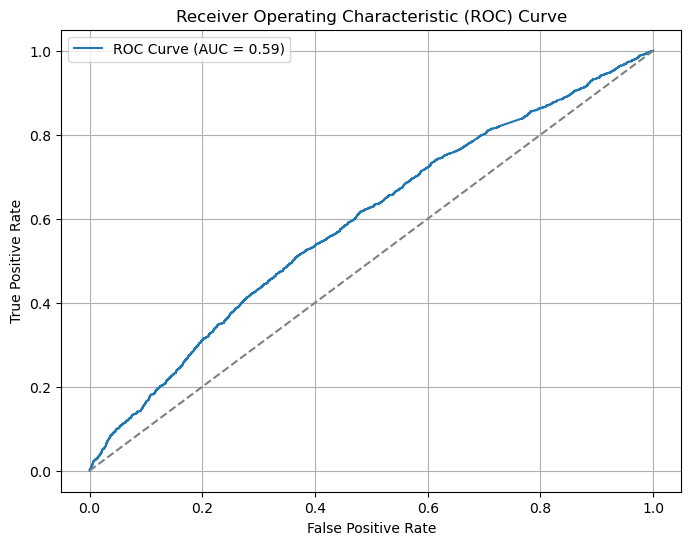

In [58]:
non_lag_features = ["plusMinusPoints", "increase_playing_time"]
lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]
target_col = "outperform_next"

training_dct = create_training_dataset(
    scores, non_lag_features, lag_features, target_col, diff_threshold=5
)

lagged_feat_names = training_dct["lagged_feat_names"]
full_df = training_dct["df"]


# Define the logic for 5 discrete values
def playing_time_change(current, previous):
    diff = current - previous
    if diff >= 20:  # Strongly Positive
        return 1
    elif diff >= 15:  # Positive
        return 0.5
    elif diff < -15:  # Negative
        return -0.5
    elif diff < -20:  # Strongly Negative
        return -1
    else:
        return 0


full_df["increase_playing_time"] = full_df.apply(
    lambda row: playing_time_change(row["minutes"], row["minutes_lag_1"]), axis=1
)


# Split training/validation sets
train_size = int(len(full_df) * 0.8)
train_df = full_df.iloc[:train_size]
test_df = full_df.iloc[train_size:]

train_features = non_lag_features + lagged_feat_names

result_dct = train_and_plot(train_df, test_df, train_features, target_col)
y_probs = result_dct["y_prob"][:, 1]
y_preds = (y_probs >= 0.5).astype(int)
y_true = test_df[target_col]


results = evaluate_prediction(y_true, y_probs, y_preds)

compute_auc_roc(
    y_true,
    y_probs,
)

## XGBoost w/ general sentiment

Sliding Window MAE: 16.779297549188815
Model MAE: 0.4316534345875043

Evaluation Metrics
----------------------------------------
Accuracy: 0.568
AUC (ROC): 0.567
F1 Score: 0.432
Precision: 0.513, Recall: 0.374

Confusion Matrix:
TN, FP
FN, TP

Confusion Matrix (Counts):
[[2341  905]
 [1596  952]]

Confusion Matrix (Percent of Column):
[[59.46 48.73]
 [40.54 51.27]]
----------------------------------------
AUC: 0.566656969911525


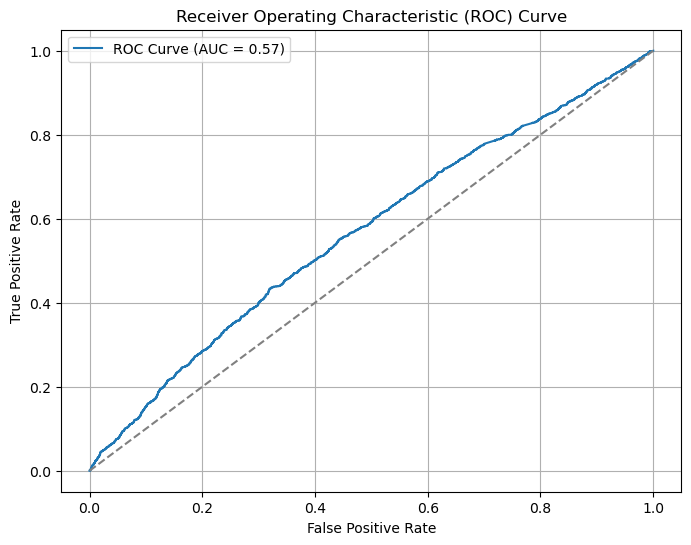

In [35]:
non_lag_features = ["plusMinusPoints", "general_sentiment"]
lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]
target_col = "outperform_next"

training_dct = create_training_dataset(
    scores, non_lag_features, lag_features, target_col, diff_threshold=5
)

lagged_feat_names = training_dct["lagged_feat_names"]
full_df = training_dct["df"]
choices = [-1, -0.5, 0, 0.5, 1]
full_df["general_sentiment"] = np.random.choice(choices, size=len(full_df))

# Split training/validation sets
train_size = int(len(full_df) * 0.8)
train_df = full_df.iloc[:train_size]
test_df = full_df.iloc[train_size:]

train_features = non_lag_features + lagged_feat_names

result_dct = train_and_plot(train_df, test_df, train_features, target_col)
y_probs = result_dct["y_prob"][:, 1]
y_preds = (y_probs >= 0.5).astype(int)
y_true = test_df[target_col]


results = evaluate_prediction(y_true, y_probs, y_preds)

compute_auc_roc(
    y_true,
    y_probs,
)

## XGBoost with All LLM Features

Sliding Window MAE: 16.779297549188815
Model MAE: 0.4275112185018985

Evaluation Metrics
----------------------------------------
Accuracy: 0.572
AUC (ROC): 0.574
F1 Score: 0.448
Precision: 0.518, Recall: 0.394

Confusion Matrix:
TN, FP
FN, TP

Confusion Matrix (Counts):
[[2312  934]
 [1543 1005]]

Confusion Matrix (Percent of Column):
[[59.97 48.17]
 [40.03 51.83]]
----------------------------------------
AUC: 0.5739350979976805


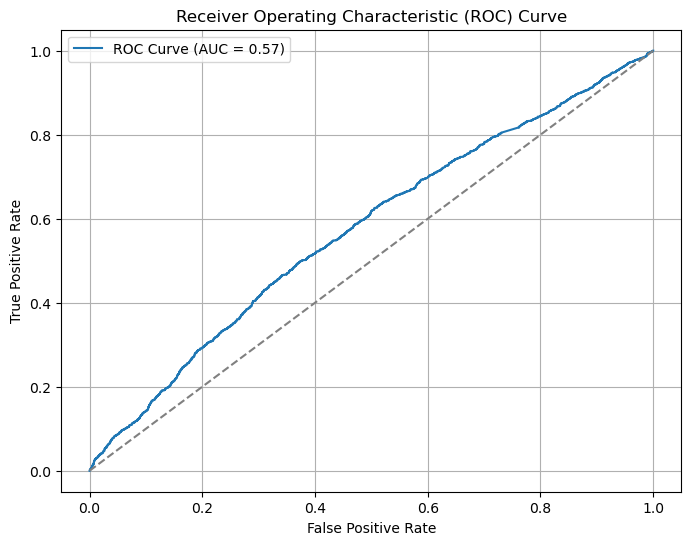

In [36]:
non_lag_features = ["plusMinusPoints", "increase_playing_time", "injured"]
lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]
target_col = "outperform_next"

training_dct = create_training_dataset(
    scores, non_lag_features, lag_features, target_col, diff_threshold=5
)

lagged_feat_names = training_dct["lagged_feat_names"]
full_df = training_dct["df"]


# Define the logic for 5 discrete values
def playing_time_change(current, previous):
    diff = current - previous
    if diff >= 20:  # Strongly Positive
        return 1
    elif diff >= 15:  # Positive
        return 0.5
    elif diff < -15:  # Negative
        return -0.5
    elif diff < -20:  # Strongly Negative
        return -1
    else:
        return 0


full_df["increase_playing_time"] = full_df.apply(
    lambda row: playing_time_change(row["minutes"], row["minutes_lag_1"]), axis=1
)


# Split training/validation sets
train_size = int(len(full_df) * 0.8)
train_df = full_df.iloc[:train_size]
test_df = full_df.iloc[train_size:]

train_features = non_lag_features + lagged_feat_names

result_dct = train_and_plot(train_df, test_df, train_features, target_col)
y_probs = result_dct["y_prob"][:, 1]
y_preds = (y_probs >= 0.5).astype(int)
y_true = test_df[target_col]


results = evaluate_prediction(y_true, y_probs, y_preds)

compute_auc_roc(
    y_true,
    y_probs,
)